# An Introduction to Qiskit Machine Learning
<br/>

<center><div><img src="images/qml.png" width="600" /></div></center>
<br>

Anna Phan<br/>
IBM Quantum, Australia

# Contents

* Overview of Qiskit Machine Learning
* Classification Example Data
* Data Encoding
* Quantum Support Vector Machine
* Variational Quantum Classifier

# Overview of Qiskit Machine Learning

<br>
<center>
    <img src="images/qml1.png">
</center>

# Classification Example Data

Some imports and seed fix.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit.utils import algorithm_globals

seed = 12345
algorithm_globals.random_seed = seed

For this classification example, we will use:

* _ad hoc dataset_ as described in [***Havlicek et al.*  Nature 567, 209-212 (2019)**](https://www.nature.com/articles/s41586-019-0980-2)

Let's create our train and test datasets using an utility function provided in Qiskit Machine Learning.

In [2]:
from qiskit_machine_learning.datasets import ad_hoc_data

train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=20,
    test_size=5,
    n=2,
    gap=0.3,
    plot_data=False, one_hot=False, include_sample_total=True
)

Here we define a helper function to plot our dataset.

In [3]:
def plot_adhoc_dataset(train_features, train_labels, test_features, test_labels, adhoc_total):
    plt.figure(figsize=(8, 8))
    plt.ylim(0, 2 * np.pi)
    plt.xlim(0, 2 * np.pi)
    plt.imshow(np.asmatrix(adhoc_total).T, interpolation='nearest',
               origin='lower', cmap='RdBu', extent=[0, 2 * np.pi, 0, 2 * np.pi])

    plt.scatter(train_features[np.where(train_labels[:] == 0), 0], train_features[np.where(train_labels[:] == 0), 1],
                marker='s', facecolors='w', edgecolors='b', label="A train")
    plt.scatter(train_features[np.where(train_labels[:] == 1), 0], train_features[np.where(train_labels[:] == 1), 1],
                marker='o', facecolors='w', edgecolors='r', label="B train")
    plt.scatter(test_features[np.where(test_labels[:] == 0), 0], test_features[np.where(test_labels[:] == 0), 1],
                marker='s', facecolors='b', edgecolors='w', label="A test")
    plt.scatter(test_features[np.where(test_labels[:] == 1), 0], test_features[np.where(test_labels[:] == 1), 1],
                marker='o', facecolors='r', edgecolors='w', label="B test")

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title("Ad hoc dataset for classification")

    plt.show()

Now plot the datasets. In this notebook we have a *pre-defined* utility function for plotting datasets.

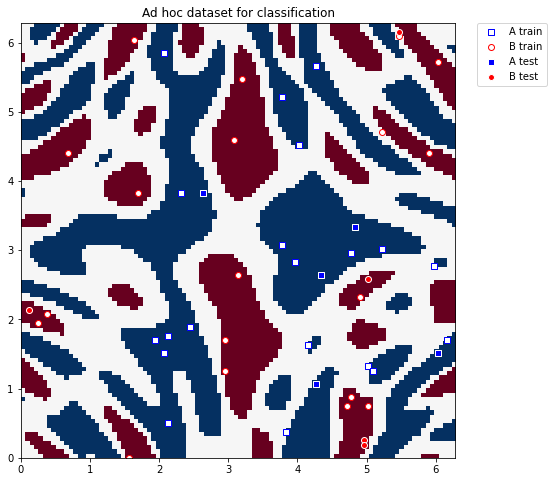

In [4]:
plot_adhoc_dataset(train_features, train_labels, test_features, test_labels, adhoc_total)

Here is an example of a datapoint from each class:

In [5]:
print(train_features[0], train_labels[0])
print(train_features[20], train_labels[20])

[2.07345115 5.84336234] 0
[1.57079633 0.        ] 1


# Data Encoding

Data representation is crucial for the success of machine learning models. For classical machine learning, this question usually takes the form how to represent the data numerically, so that it can be best processed by a classical machine learning algorithm. 

For quantum machine learning, this question is similar, but more fundamental: how to represent and efficiently input the data into a quantum system, so that it can be processed by a quantum machine learning algorithm. This is usually referred to as data encoding, but is also called data embedding or loading.

There are various methods for data encoding, but the one generally used is arbitary encoding, which encodes 𝑁 features as rotations on 𝑁 parameterized gates on 𝑛 qubits, where 𝑛≤𝑁. It only encodes one datapoint at a time, rather than a whole dataset and uses a constant depth quantum circuit and 𝑛≤𝑁 qubits, meaning it can be run on current quantum hardware.

# Data Encoding Examples

For example, to use the Qiskit [**`EfficientSU2`**](https://qiskit.org/documentation/stubs/qiskit.circuit.library.EfficientSU2.html) circuit to encode 12 features, would only use 3 qubits:

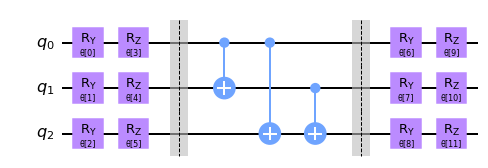

In [6]:
from qiskit.circuit.library import EfficientSU2

circuit = EfficientSU2(num_qubits=3, reps=1, insert_barriers=True)
circuit.decompose().draw(output='mpl')

Here we encode the datapoint $x = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2]$ with 12 features, using each of the parameterized gates to encode a different feature.

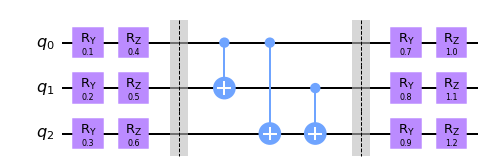

In [7]:
x = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2]

encode = circuit.bind_parameters(x)
encode.decompose().draw(output='mpl')

The Qiskit [**`ZZFeatureMap`**](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html) circuit with 3 qubits, only encodes a datapoint of 3 features, despite having 6 parameterized gates:

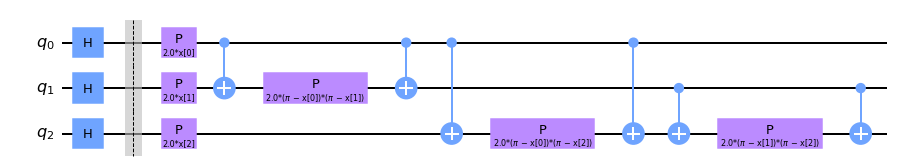

In [8]:
from qiskit.circuit.library import ZZFeatureMap

circuit = ZZFeatureMap(3, reps=1, insert_barriers=True)
circuit.decompose().draw(output='mpl')

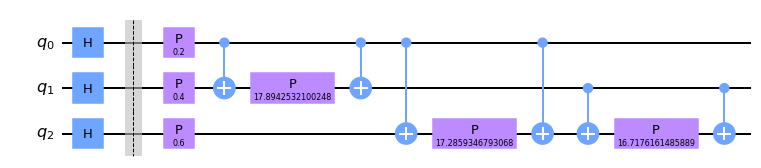

In [9]:
x = [0.1,0.2,0.3]

encode = circuit.bind_parameters(x)
encode.decompose().draw(output='mpl')

The choice of which parameterized quantum circuit to use to encode what data is an active area of research.

# Quantum Support Vector Machine

Introduced in [***Havlicek et al.*  Nature 567, 209-212 (2019)**](https://www.nature.com/articles/s41586-019-0980-2), the quantum support vector classification algorithm consists of these steps:

<center><img src="images/qsvm.png" width="1000"></center> 


1. Build the train and test quantum kernel matrices.
    1. For each pair of datapoints in the training dataset $\mathbf{x}_{i},\mathbf{x}_j$, apply the feature map and measure the transition probability: $ K_{ij} = \left| \langle 0 | \mathbf{U}^\dagger_{\Phi(\mathbf{x_j})} \mathbf{U}_{\Phi(\mathbf{x_i})} | 0 \rangle \right|^2 $.
    2. For each training datapoint $\mathbf{x_i}$ and testing point $\mathbf{y_i}$, apply the feature map and measure the transition probability: $ K_{ij} = \left| \langle 0 | \mathbf{U}^\dagger_{\Phi(\mathbf{y_i})} \mathbf{U}_{\Phi(\mathbf{x_i})} | 0 \rangle \right|^2 $.
2. Use the train and test quantum kernel matrices in a classical support vector machine classification algorithm.

# QSVM Example

With our training and testing datasets ready, we set up the QuantumKernel class to calculate a kernel matrix using the [**`ZZFeatureMap`**](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html), and the Aer `qasm_simulator` using 1024 shots.

In [10]:
from qiskit import Aer
from qiskit.utils import QuantumInstance

quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=1024,
                                   seed_simulator=seed, seed_transpiler=seed)

In [11]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel

zz_feature_map = ZZFeatureMap(feature_dimension=2, reps=2)

zz_kernel = QuantumKernel(feature_map=zz_feature_map, quantum_instance=quantum_instance)

Here we compute and plot the training and testing kernel matrices:

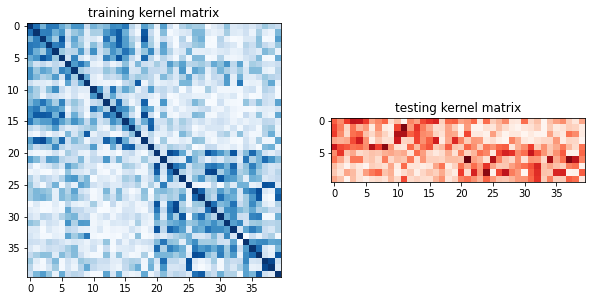

In [12]:
train_matrix = zz_kernel.evaluate(x_vec=train_features)
test_matrix = zz_kernel.evaluate(x_vec=test_features, y_vec=train_features)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(train_matrix),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(test_matrix),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("testing kernel matrix")
plt.show()

The `scikit-learn` [**`svc`**](https://scikit-learn.org/stable/modules/svm.html) algorithm allows us to define a [**custom kernel**](https://scikit-learn.org/stable/modules/svm.html#custom-kernels) in two ways: by providing the kernel as a callable function or by precomputing the kernel matrix. We can do either of these using the [**`QuantumKernel`**](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.kernels.QuantumKernel.html?highlight=quantumkernel) class in Qiskit.

The following code takes the training and testing kernel matrices we calculated above and  provides them to the `scikit-learn` `svc` algorithm:

In [13]:
from sklearn.svm import SVC

zzpc_svc = SVC(kernel='precomputed')
zzpc_svc.fit(train_matrix, train_labels)
zzpc_score = zzpc_svc.score(test_matrix, test_labels)

print(f'Precomputed kernel classification test score: {zzpc_score}')

Precomputed kernel classification test score: 1.0


The following code gives the kernel as a callable function:

In [14]:
zzcb_svc = SVC(kernel=zz_kernel.evaluate)
zzcb_svc.fit(train_features, train_labels)
zzcb_score = zzcb_svc.score(test_features, test_labels)

print(f'Callable kernel classification test score: {zzcb_score}')

Callable kernel classification test score: 1.0


# Variational Quantum Classifier

Variational algorithms were introduced in 2014, with the variational eigensolver in [***Peruzzo et al.* Nature Communications, 5:4213 (2014)**](https://doi.org/10.1038/ncomms5213) and the quantum approximate optimization algorithm in [***Farhi et al.* arXiv:1411.4028**](https://arxiv.org/abs/1411.4028). They are near-term algorithms, that can be executed on current quantum computers in concert with classical computers. 

Using a parameterized quantum circuit, or ansatz, $U(\theta)$, we prepare a state $\psi(\theta) \rangle = U(\theta) |0 \rangle$, and measure the expectation value using a quantum computer. We define a cost function $C(\theta)$, that determines how good $\theta$ is for the problem we are trying to solve. We use a classical computer to calculate the cost function and provide updated circuit parameters using an optimization algorithm. The goal of the algorithm is to find the circuit parameters $\theta$ for the parameterized quantum circuit $U(\theta)$ that minimizes the cost function $C(\theta)$. 

<figure><center>
  <img src="images/va.png" style="width:800px">
</figure></center>


The variational quantum classifier is a variational algorithm where the measured expectation value is interpreted as the output of a classifier, introduced by mutiple groups in 2018. For a binary classification problem, with input data vectors $\vec{x}_i$ and binary output labels $y_i = \{0,1\}$; for each input data vector, we build a parameterized quantum circuit whose outputs is the quantum state: 
$$ |\psi(\vec{x}_i;\vec{\theta}) \rangle =  U_{W(\vec{\theta})}U_{\phi(\vec{x}_i)}|0 \rangle$$
where $U_{W(\vec{\theta})}$ corresponds to the variational circuit unitary and $U_{\phi(\vec{x}_i)}$ corresponds to the data encoding circuit unitary. After creating and measuring the circuit of $n$ qubits, we are left with a $n$ length bitstring from which we must derive a binary output which will be our classification result. This is done with the help of a boolean function $f: \{0, 1\}^{n} \rightarrow \{0, 1\}$. The parity function tends to be used.

<figure><center>
  <img src="images/vqc.png" style="width:1000px">
</figure></center>

In the training phase, we are trying to find the values for $\vec{\theta}$ that give us the best predictions. The classical computer compares the predicted labels $\hat{y_i}$, to the provided labels $y_i$, and we calculate the success of our predictions using a cost function. Based on this cost, the classical computer chooses another value for $\vec{\theta}$ using a classical optimization algorithm. This new $\vec{\theta}$ is then used to run a new circuit, and the process is repeated until the cost function stabilizes.

It is essential to choose a variational circuit that is shorter depth (hardware efficient), less parameters (faster training) while making sure it is expressive (covers more parameter space) and has high entangling capability (to make it more 'quantum' and less 'classical'). Building variational circuits with such conflicting properties, similar to the study of data encoding, is an active field of research.

# VQC Example

Qiskit has an implementation of the variational quantum classifer in the [**`VQC`**](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.VQC.html) class. Let's use it on this dataset. 

First, we need to one hot encode our labels, as required by the algorithm.

In [15]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(train_labels.reshape(-1, 1)).toarray()
test_labels_oh = encoder.fit_transform(test_labels.reshape(-1, 1)).toarray()

Second, we need to prepare our classification circuit. We will use the same `ZZFeatureMap` as above as our data encoding circuit. 

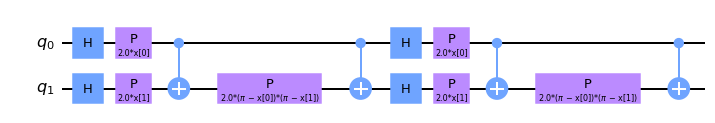

In [16]:
feature_map = ZZFeatureMap(feature_dimension=2, reps=2)
feature_map.decompose().draw('mpl')

For the variational form, we will use [**`RealAmplitudes`**](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html), introduced in [**_Kandala et al._  Nature 549, 242–246 (2017)**](https://doi.org/10.1038/nature23879).

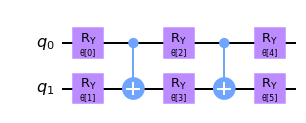

In [17]:
from qiskit.circuit.library import RealAmplitudes

var_form = RealAmplitudes(2, reps=2)
var_form.decompose().draw('mpl')

Third, we set up and run the `VQC` algorithm, setting initial variational circuit parameters for reproducibility and creating a callback function to plot the optimization steps.

In [18]:
# Optimizer callback function for plotting purposes
def store_intermediate_result(evaluation, parameter, cost, stepsize, accept):
    evaluations.append(evaluation)
    parameters.append(parameter)
    costs.append(cost)

In [19]:
#initial_point = np.random.random(var_form.num_parameters)
initial_point = np.array([0.78969092, 0.50252316, 0.45244703, 
                          0.83243915, 0.79595478, 0.42169888])

In [20]:
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.algorithms.optimizers import SPSA

vqc = VQC(feature_map=feature_map,
          ansatz=var_form,
          loss='cross_entropy',
          optimizer=SPSA(callback=store_intermediate_result),
          initial_point=initial_point,
          quantum_instance=Aer.get_backend('statevector_simulator'))

In [21]:
parameters = []
costs = []
evaluations = []

vqc.fit(train_features, train_labels_oh)

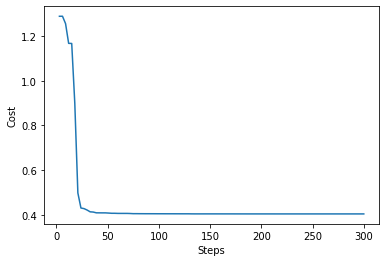

In [22]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

Fourth, we evaluate the trained classifier on the test data.

In [23]:
vqc.score(test_features, test_labels_oh)

1.0

# Resources

- A blog post "Introducing Qiskit Machine Learning":<br>
https://medium.com/qiskit/introducing-qiskit-machine-learning-5f06b6597526
<br>

- Qiskit Machine Learning tutorials:<br>
https://qiskit.org/documentation/machine-learning/tutorials/
<br>

- Qiskit Machine Learning textbook course:<br>
https://qiskit.org/learn/course/machine-learning-course
<br>

<center>
Thank You!
</center>

In [24]:
import qiskit.tools.jupyter

%qiskit_version_table